# Figures for paper

In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from mri_maps import *
from enrichments import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");
%R source("../code/brainspanPlots.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


---

## Set gradient version

In [4]:
pca = gradientVersion(approach='pca').fit('hcp_base')
pca_hcp_3d_ds8 = gradientVersion(approach='pca').fit('hcp_3donors_ds8')
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_3donors_ds8
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_ds9
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [5]:
hcp_version = dm_hcp_ds9

---

## 1 — Gradients on brains

In [398]:
hcp_scores = (pd.concat({
    'PCA, all regions and genes': pca.clean_scores(),
    'PCA, only 3+ donor regions,\ntop 20% DS genes': pca_hcp_3d_ds8.clean_scores(),
    'DM, all regions,\ntop 10% DS genes': dm_hcp_ds9.clean_scores(),
    'DM, only 3+ donor regions,\ntop 50% DS genes': dm_hcp_3d_ds5.clean_scores(),
    # 'DM, only top 10% DS genes,\nall regions': dm_hcp_ds9.clean_scores(),
})
        .reset_index(level=0).rename({'level_0':'version'},axis=1)
         )

In [337]:
%%R -i hcp_scores -w 2000 -h 1000
# plot_hcp(hcp_scores, three=T) & theme(text=element_text(size=36))

NULL


## 1 — Triplets filtering

Load triplets data from pickles since triplets are slow to compute

In [338]:
triplets_hcp = load_pickle('triplets_hcp')
triplets_hcp_3donors = load_pickle('triplets_hcp_3donors')

In [339]:
triplets_pca = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='pca'), with_coefs=False)
triplets_dm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
triplets_pca_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='pca'), with_coefs=False)
triplets_dm_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

In [376]:
triplets_dict = {
    'PCA': triplets_pca, 
    'PCA, only 3+ donor regions': triplets_pca_3d,
    'Diffusion Maps (DM)': triplets_dm,
    'DM, only 3+ donor regions': triplets_dm_3d
}

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )

df_triplets_highlight = pd.DataFrame({'method': triplets_dict.keys(), 'DS':[0,.8,.9,.5]}).assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))

In [479]:
hcp_scatter = (hcp_scores.set_index(['version', 'label']).stack().unstack(0)
               .iloc[:,[0,1]].reset_index(1).set_axis(['G','x','y'],axis=1)
              )

# Fig 1

Message: With careful processing, PC2 and PC3 of the AHBA are robust and generalizable.

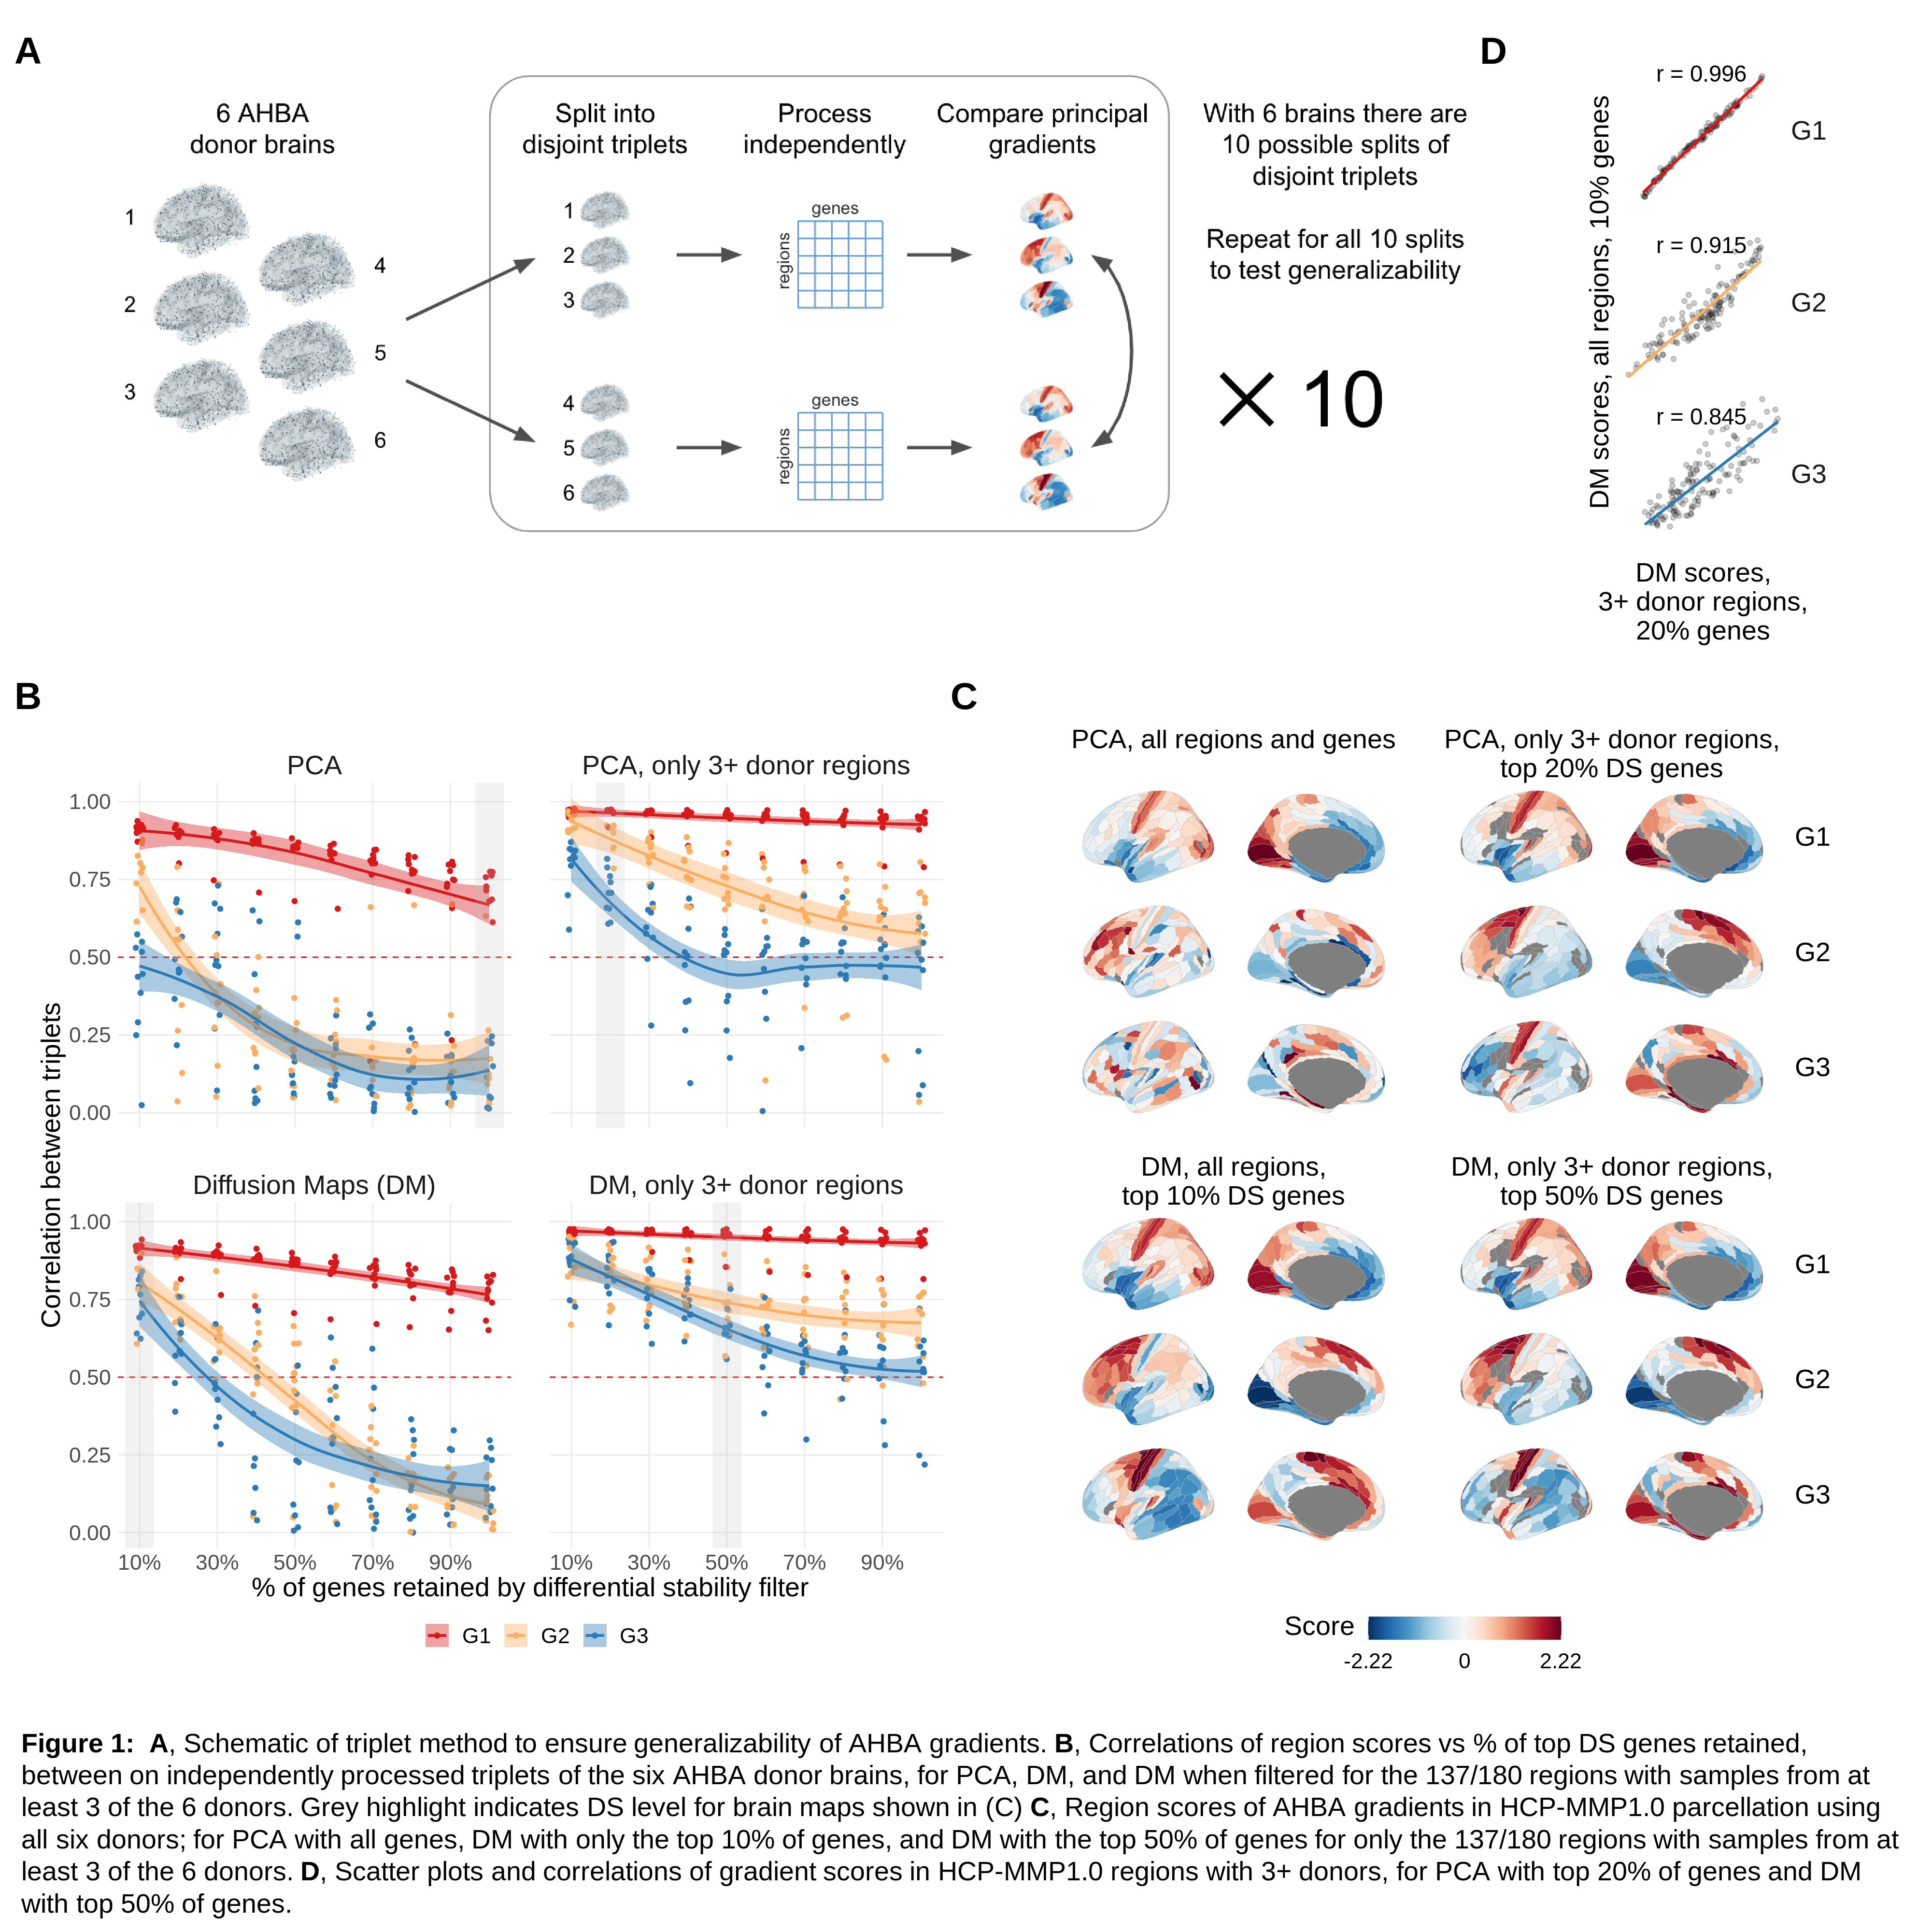

In [481]:
%%R -w 20 -h 20 --units in -r 200 -i triplets_plot_v2 -i donor_counts -i stability -i hcp_scores -i df_triplets_highlight -i hcp_bs_mapping -i cortex_scores -i cortex_corrs
source("../code/Rplots.R")
source("../code/brainPlots.R")
# source("../code/brainspanPlots.R")
library(magick)
img <- image_read("../data/schematics/fig1_schem.png")

g0 <- image_ggplot(img)
# g1a <- plot_ds_dist_hcp(stability)
# g1b <- plot_dist_donors_hcp(donor_counts)
g2 <- plot_triplets_v2(triplets_plot_v2, facet='w') + geom_vline(data=df_triplets_highlight, aes(xintercept=DS), size=10, alpha=.2, color='grey')
g3a <- plot_hcp(hcp_scores %>% filter(str_detect(version, 'PCA')), spacing_x=2) + theme(legend.position='none', strip.text.y=element_text(margin=margin(l=10)))
g3b <- plot_hcp(hcp_scores %>% filter(str_detect(version, 'DM')), spacing_x=2) + theme(legend.position='bottom', strip.text.y=element_text(margin=margin(l=10))) + 
        guides(fill=guide_colorbar(title='Score', barwidth=10, title.vjust=1)) + plot_layout(tag_level='new')
# theme(legend.position='right') + guides(fill=guide_colorbar(title='Score', barheight=10, title.hjust=0))
g4 <- plot_scatter_corrs(hcp_scatter, xlab='DM scores,\n3+ donor regions,\n20% genes', ylab='DM scores, all regions, 10% genes')

# g4a <- plot_bs_mapping(hcp_bs_mapping)
# g4b <- plot_ahba_bs_scatter(cortex_scores, cortex_corrs)

caption <- paste("**Figure 1:**",
                "**A**, Schematic of triplet method to ensure generalizability of AHBA gradients.",
                "**B**, Correlations of region scores vs % of top DS genes retained, between on independently processed triplets of the six AHBA donor brains, for PCA, DM, and DM when filtered for the 137/180 regions with samples from at least 3 of the 6 donors.",
                        "Grey highlight indicates DS level for brain maps shown in (C)",
                "**C**, Region scores of AHBA gradients in HCP-MMP1.0 parcellation using all six donors; for PCA with all genes, DM with only the top 10% of genes, and DM with the top 50% of genes for only the 137/180 regions with samples from at least 3 of the 6 donors.",
                "**D**, Scatter plots and correlations of gradient scores in HCP-MMP1.0 regions with 3+ donors, for PCA with top 20% of genes and DM with top 50% of genes."
                # "**G**, BrainSpan RNA-seq gene expression for adult brains (18-40 yrs) in matched regions scored with gene weights from AHBA gradients, vs AHBA gradient mean scores in the matched HCP regions."
)


layout <- c(
  area(t = 1, b = 3, l = 1, r = 8),
  area(t = 4, b = 7, l = 1, r = 5),
  area(t = 4, b = 5, l = 6, r = 10),
  area(t = 6, b = 7, l = 6, r = 10),
  area(t = 1, b = 3, l = 9, r = 10)
)
# plot <- g0 / (g2 | (g3a / g3b))
plot <- g0 + g2 + g3a + g3b + g4 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20), 
    strip.text=element_text(size=20),
    strip.text.x=element_text(size=20),
    strip.text.y=element_text(size=20),
    # plot.margin = margin(t=10, r=10, b=10, l=10, "pt"),
    plot.tag = element_text(size=28, face='bold', vjust=-2)
)


annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated
# ggsave(filename='test2.png', device='png')

---

## Brainspan mapping

In [6]:
bs_cortex_mapping = get_bs_cortex_mapping()
hcp_bs_mapping = get_hcp_bs_mapping(bs_cortex_mapping)

In [7]:
bs_exp, bs_col, bs_row = get_brainspan()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, bs_cortex_mapping)
bs_agg = aggregate_brainspan_by_age(bs_clean)

## Brainspan development

In [8]:
weights_version = dm_hcp_3d_ds5

In [9]:
scores_cortex = get_mapped_scores(weights_version, hcp_bs_mapping)
bs_scores = compute_brainspan_scores(bs_agg, weights_version, bs_cortex_mapping)

In [10]:
age_groups = get_age_groups()
bs_scores_corr = correlate_bs_scores(bs_scores, scores_cortex, age_groups=age_groups)

## Brainspan adult correlation

In [11]:
cortex_scores, cortex_corrs = get_cortex_scores(bs_scores, scores_cortex, age_groups, bs_cortex_mapping)

In [13]:
scores_plot = make_brain_scores(weights_version, hcp_bs_mapping, bs_scores)

## Gene weight vs DS

In [85]:
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')

weights_ds = (dm_hcp_3d_ds5.weights
            .iloc[:,:3].set_axis(['G1','G2','G3'],axis=1)
            .join(stability)
             )

## Cell enrichments

In [27]:
cell_genes = get_cell_genes()
weights_version = dm_hcp_3d_ds5
weights_version.fit_weights();

weights = weights_version.weights.iloc[:,:3]
gene_masks = match_cell_genes(cell_genes, weights)
nulls = shuffle_gene_weights(weights, n=10000, rank=False)

In [28]:
gene_masks = match_cell_genes(cell_genes, weights)

In [29]:
true_scores, null_scores = compute_cell_scores(
    weights, nulls, gene_masks, how='mean')

cell_null_p = compute_null_p(true_scores, null_scores, adjust='fdr_bh')

## STRING enrichments

In [89]:
enrichments_keywords = combine_enrichments('dm_hcp_3d_ds5', 'Keyword', include_g1=True)
enrichments_process = combine_enrichments('dm_hcp_3d_ds5', 'Process', include_g1=True)

In [90]:
hcp_scores_single = dm_hcp_ds9.clean_scores(flips=[])

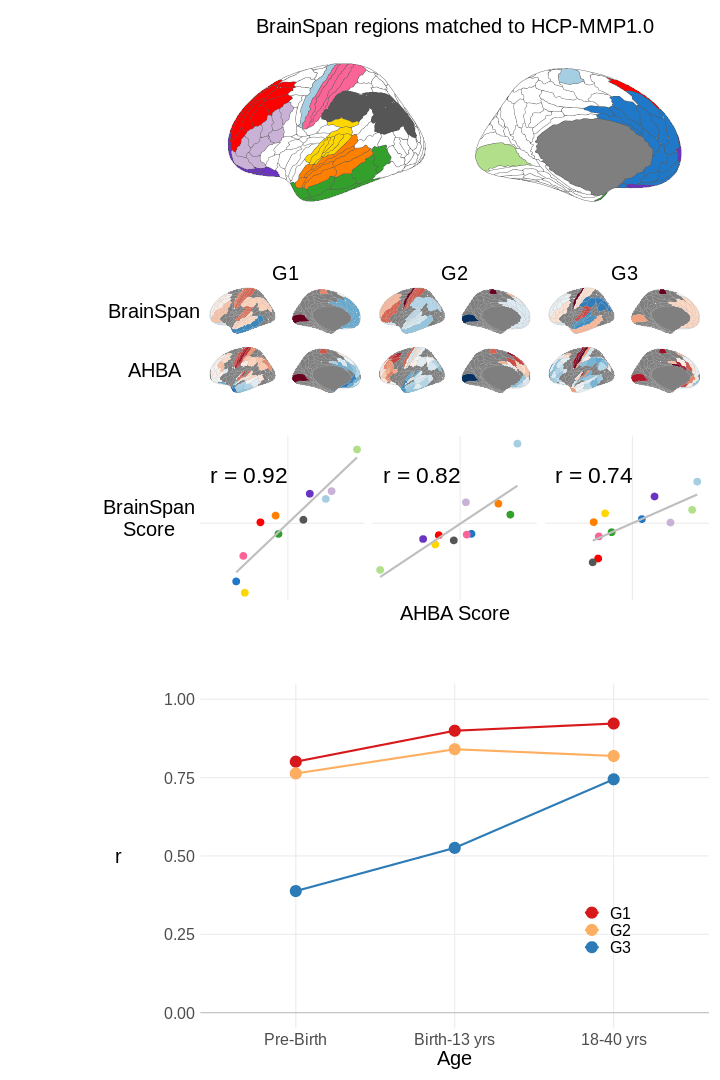

In [28]:
%%R -w 10 -h 15 --units in  -i hcp_bs_mapping -i cortex_scores -i cortex_corrs -i scores_plot -i bs_scores_corr
source("../code/brainspanPlots.R")
source("../code/brainPlots.R")
g0 <- plot_bs_mapping(hcp_bs_mapping)
g1 <- plot_hcp(scores_plot, facet='v', switch='y') + 
    theme(strip.text.x=element_text(size=20), strip.text.y.left=element_text(size=20),
        legend.position='none')
g2 <- plot_ahba_bs_scatter(cortex_scores, cortex_corrs, facet='h', size=3)
g3 <- plot_bs_scores_corr(bs_scores_corr) + 
    theme(
        axis.text.y=element_text(margin=margin(r=-90, unit='pt')),
        axis.title.y=element_text(margin=margin(r=-120, unit='pt'), angle=0, vjust=0.5),
        text=element_text(size=20), legend.position=c(.8,.3),  
         )

layout <- c(
    area(t=1,b=3,l=1,r=5),
    area(t=4,b=5,l=1,r=5),
    area(t=6,b=8,l=1,r=5),
    area(t=9,b=13,l=1,r=5)
)
    
g0 + g1 + g2 + g3 + plot_layout(design=layout)

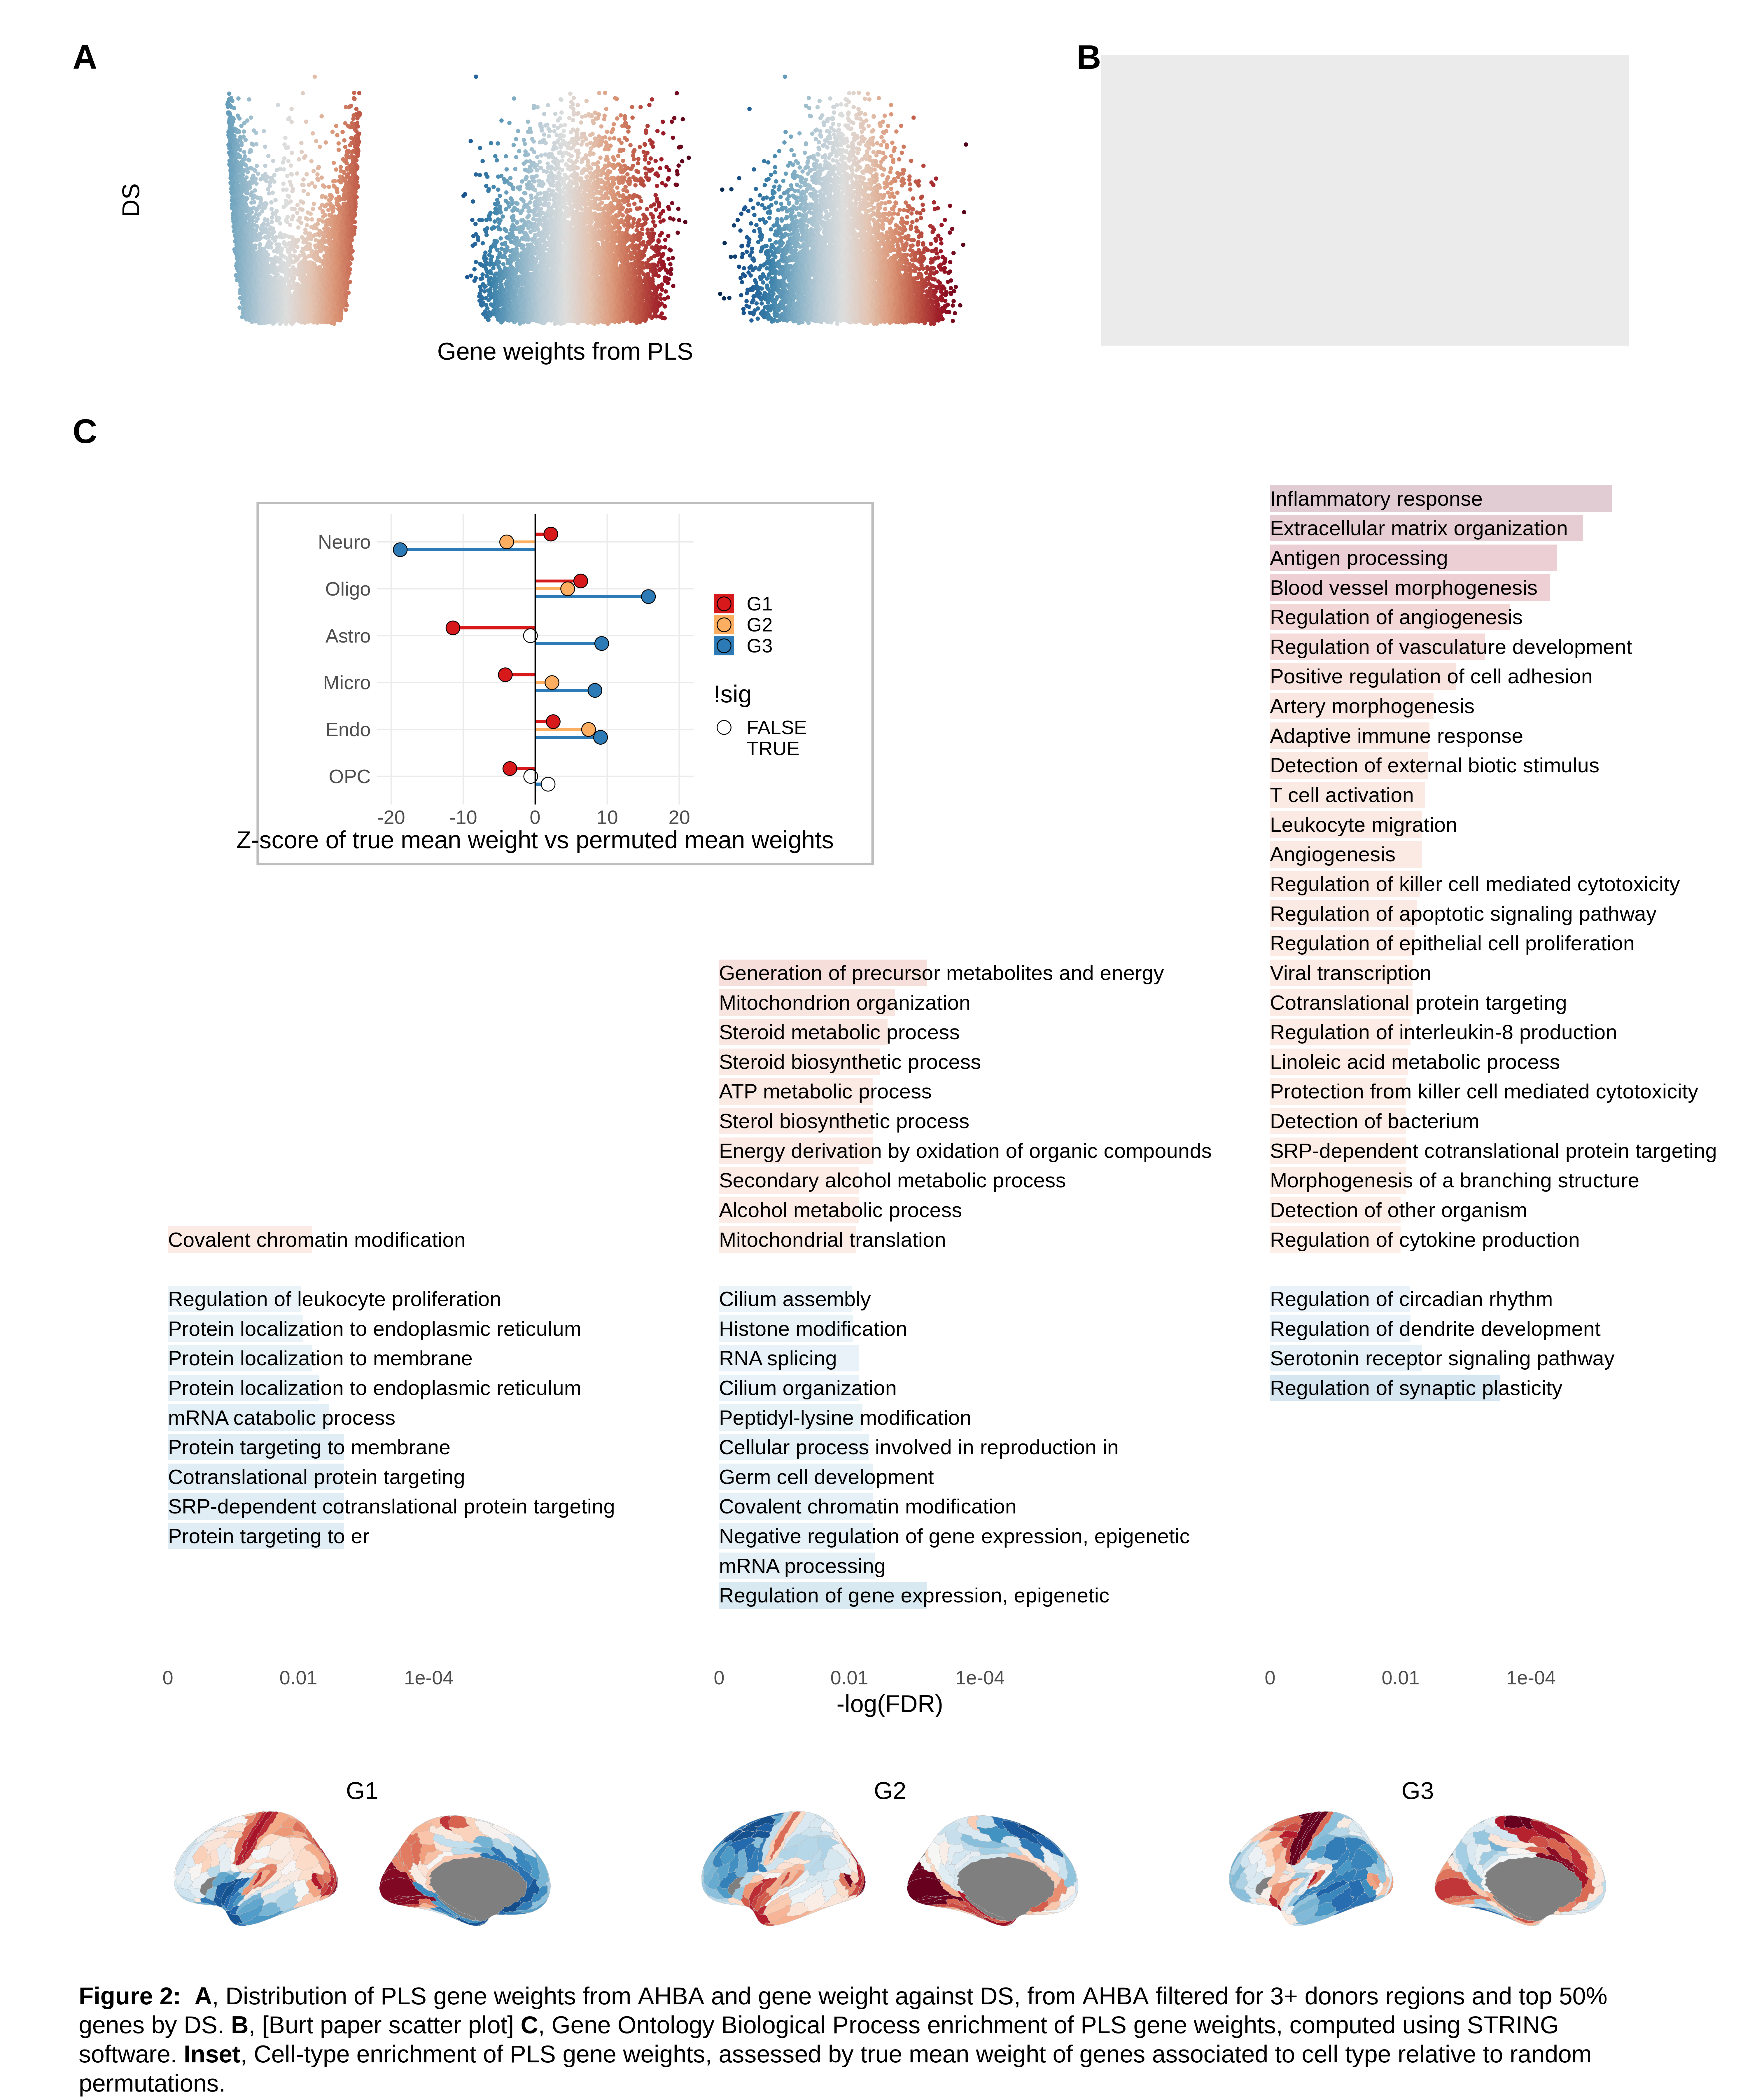

In [91]:
%%R -w 20 -h 24 --units in -r 300 -i hcp_scores_single -i bs_scores_corr -i cell_null_p -i enrichments_process -i enrichments_keywords -i weights_ds
source("../code/enrichmentsPlots.R")
source("../code/brainspanPlots.R")

g0 <- plot_weights_ds(weights_ds)
# g0a <- plot_weights_dist(weights_ds)
g1 <- ggplot() + geom_blank()
g2 <- plot_enrichments_v2(enrichments_process, size=6) + theme(strip.text.x=element_blank())
g3 <- plot_cell_dotplot(cell_null_p) + plot_layout(tag_level='new') + theme(plot.background = element_rect(colour = "grey", fill=NA, size=2))
g4 <- plot_hcp_wide(hcp_scores_single, spacing=6) + guides(fill='none') + plot_layout(tag_level='new') + theme(strip.text.x=element_text(size=20))

layout <- c(
  area(t = 1, b = 4, l = 1, r = 5),
  area(t = 1, b = 4, l = 6, r = 10),
  area(t = 5, b = 20, l = 1, r = 10),
  area(t = 6, b = 9, l = 2, r = 4),
  area(t = 21, b = 22, l = 1, r = 10)
)

plot <- g0 + g1 + g2 + g3 + g4 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20),
    plot.margin = margin(t=10, r=50, b=10, l=30, "pt"),
    plot.tag = element_text(size=28, face='bold', vjust=-2)
)

caption <- paste("**Figure 2:**",
                 "**A**, Distribution of PLS gene weights from AHBA and gene weight against DS, from AHBA filtered for 3+ donors regions and top 50% genes by DS.",
                 "**B**, [Burt paper scatter plot]",
                 "**C**, Gene Ontology Biological Process enrichment of PLS gene weights, computed using STRING software.",
                 "**Inset**, Cell-type enrichment of PLS gene weights, assessed by true mean weight of genes associated to cell type relative to random permutations."
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

# Fig 3 — maps

In [495]:
maps=get_maps()
hcp_scores = dm_hcp_ds9.clean_scores()
corrs = get_corrs(hcp_scores, maps, method='pearson')

In [497]:
sim_grads = np.load("../outputs/permutations/sim_gradients_1000.npy")
null_corrs = corr_nulls_from_grads(sim_grads, hcp_scores, maps, method='pearson')
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')

In [510]:
short_names = {
        'T1w/T2w':'T1T2',
        'Cortical Thickness':'CT',
        'fMRI PC1':'fMRI',
        'Oxygen Metabolism (CMRO2)':'Oxy.',
        'Glucose Metabolism (CMRGlu)':'Glu.',
        'Glycolytic Index (CMRO2/CMRGlu)':'GI',
        'Developmental Expansion':'Dev.',
        'Evolutionary Expansion':'Evo.',
        'Externopyramidisation':'Ext.',
        'Cerebral Blood Flow':'CBF',
        'Allometric Scaling':'Allom.',
         'NeuroSynth PC1':'NS',
}
null_p = null_p.assign(map_name = lambda x: x['map'].map(short_names))

## Scatter

In [633]:
maps_scatter_names = {
    'Oxygen Metabolism (CMRO2)':'Oxygen\nMetabolism',
    'Glycolytic Index (CMRO2/CMRGlu)':'Glycolytic\nIndex'
}
maps_scatter = (maps
                .loc[:,maps_scatter_names.keys()]
                .melt(ignore_index=False, var_name='map', value_name='map_score')
                .join(hcp_scores.set_index('label')).reset_index()
                .replace({'map':maps_scatter_names})
                .drop('G3',axis=1)
               )
maps_scatter_corrs = (null_p.query("map in @maps_scatter_names.keys()")
                      .loc[:,['map','G','true_mean','q']]
                      .replace({'map':maps_scatter_names})
                      .loc[lambda x: x['G'] != 'G3']
                     )

## PCA

In [663]:
pca_scores, pca_weights = maps_pca(maps, short_names)
pca_scores = (pca_scores.drop('PC3', axis=1).loc[:,['PC2','PC1']] * [1,-1]).reset_index()

In [666]:
ahba_scores = hcp_scores.drop('G3', axis=1)

In [725]:
both_scores_scatter = (pd.concat({
    'MRI PCA': pca_scores.set_axis(['label','G1','G2'],axis=1).set_index('label'),
    'AHBA DM': ahba_scores.set_index('label')}, 
    axis=1)
 .stack(1).reset_index().rename({'level_1':'G'},axis=1)
 .replace({'G':{'G1':'AHBA G1 v MRI PC2', 'G2':'AHBA G2 v MRI PC1'}})
)

In [712]:
both_scores_scatter

label                  G   MRI PCA   AHBA DM
0       V1  AHBA G1 - MRI PC2  2.942282  1.935876
1       V1  AHBA G2 - MRI PC1  0.460216 -2.321057
2      MST  AHBA G1 - MRI PC2  0.945194  1.653959
3      MST  AHBA G2 - MRI PC1 -0.044431 -1.122848
4       V6  AHBA G1 - MRI PC2  1.881415  1.011170
..     ...                ...       ...       ...
355     PI  AHBA G2 - MRI PC1 -2.270002 -1.286319
356  a32pr  AHBA G1 - MRI PC2 -1.146342 -1.349864
357  a32pr  AHBA G2 - MRI PC1  0.458273  0.218754
358    p24  AHBA G1 - MRI PC2 -1.338981 -1.558816
359    p24  AHBA G2 - MRI PC1 -0.003197 -0.530838

[360 rows x 4 columns]

In [708]:
%%R -i both_scores_scatter
both_scores_scatter %>% select(-label) %>% 
group_by(G) %>% summarize(cor(`MRI PCA`, `AHBA DM`, use='p')) %>%
rename_with(function(x) c('G','r'), everything())

# A tibble: 2 × 2
  G                     r
* <chr>             <dbl>
1 AHBA G1 - MRI PC2 0.709
2 AHBA G2 - MRI PC1 0.643


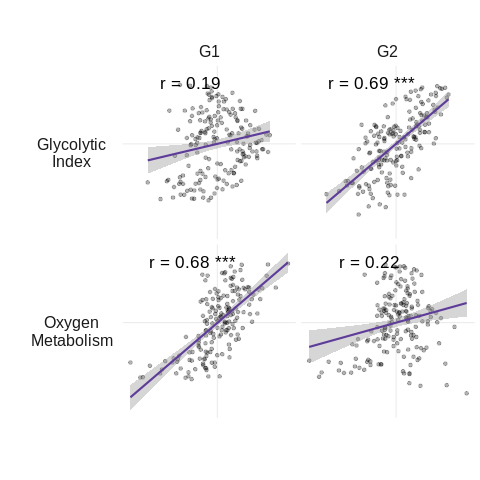

In [803]:
%%R -i pca_scores -i ahba_scores -i both_scores_scatter -i maps_scatter -i maps_scatter_corrs
source("../code/plot_maps.R")

# maps_scatter %>% head
# maps_scatter_corrs %>% head

    df <- maps_scatter %>%
    # select(-G3) %>%
    # filter(map %in% which) %>%
    gather(G, G_score, -label, -map, -map_score)
# df %>% head
    corrs <- maps_scatter_corrs %>%
    # filter(map == which) %>%
    mutate(sig_label = ifelse(q<0.001, '***', '')) %>%
    mutate(r_label=paste('r =', round(true_mean,2), sig_label)) %>%
    mutate(x=-1, y=2)

    df %>%
    mutate(map = factor(map, ordered=T, levels=rev(unique(.$map)))) %>%
    ggplot(aes(y=G_score, x=map_score)) +
    facet_grid(map~G, switch='y') +
    geom_point(alpha=.3) + 
    geom_smooth(method='lm', color=brewer.puor(5)[5]) +
    geom_text(data=corrs, aes(label=r_label, x=x, y=y), size=6, hjust=0.5, vjust=0.5) +
    # geom_text(data=corrs, aes(label=p_label, x=x, y=y), size=6, hjust=0, vjust=1) +
    scale_x_continuous(breaks=0) + scale_y_continuous(breaks=0) +
    # xlim(c(-3,3)) + ylim(c(-3,3)) +
    xlab('') + ylab('') +
    theme_minimal() +
    theme(strip.placement='outside',
          strip.text.y.left=element_text(angle=0),
          panel.grid.minor=element_blank(),
          axis.text = element_blank(),
          plot.title = element_text(hjust=0.5, vjust=1, size=20),
          aspect.ratio=1,
          text=element_text(size=20)
         )

# plot_maps(maps, ncol=1, colors=rev(brewer.puor(100)), spacing=0) + theme(legend.position='bottom')
# plot_corrs(null_p)
# plot_maps_scatter(maps_scatter, maps_scatter_corrs)
# g4 <- plot_pca_weights(pca_weights)
# g5a <- plot_ahba_mri_brains(pca_scores %>% mutate(version='MRI PCA'))
# g5b <- plot_ahba_mri_brains(ahba_scores %>% mutate(version='AHBA DM')) + plot_layout(tag_level='new')
# g6 <- plot_both_scores_scatter(both_scores_scatter)

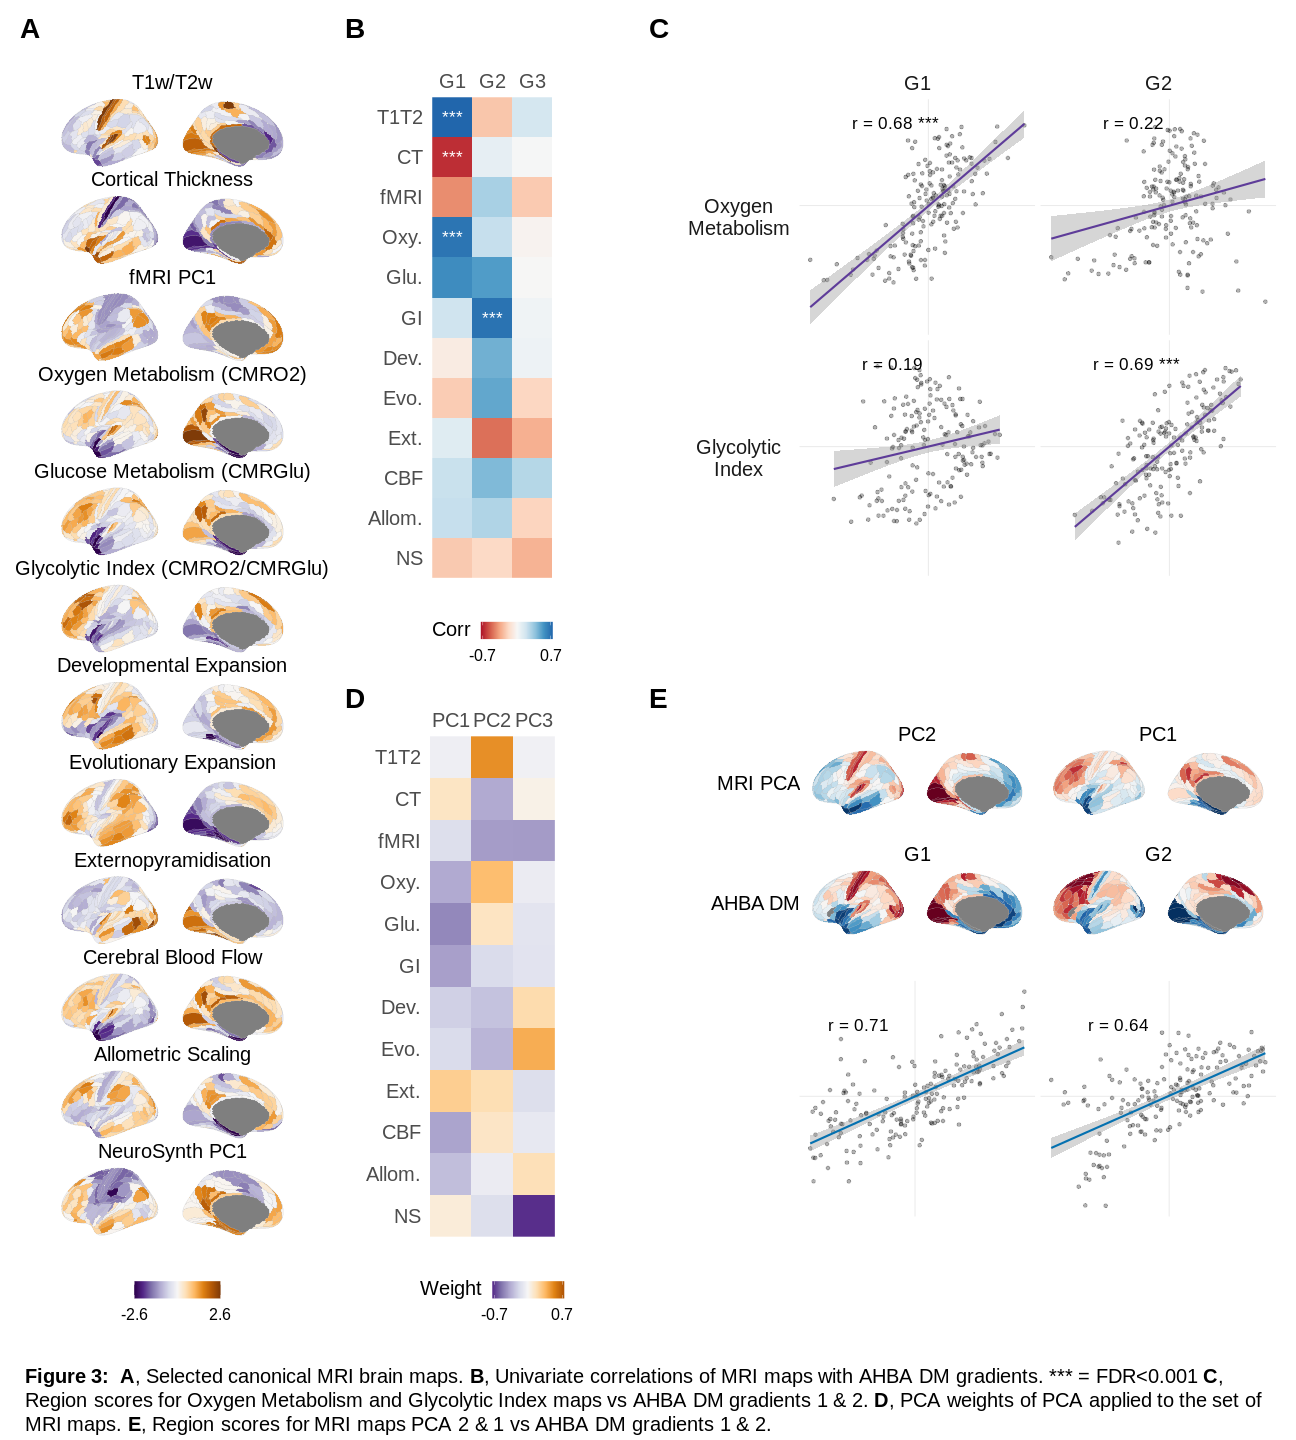

In [811]:
%%R -w 18 -h 20 --units in -i maps -i null_p -i maps_scatter -i maps_scatter_corrs -i pca_weights -i pca_scores -i ahba_scores -i both_scores_scatter
source("../code/plot_maps.R")

g1 <- plot_maps(maps, ncol=1, colors=rev(brewer.puor(100)), spacing=0) + theme(legend.position='bottom', plot.tag.position = c(0, 1))
g2 <- plot_corrs(null_p) + theme(plot.tag.position = c(0, 1))
g3 <- plot_maps_scatter(maps_scatter, maps_scatter_corrs) + theme(plot.tag.position = c(0.1, 1))
# g3a <- plot_maps_scatter(maps_scatter, maps_scatter_corrs, which='Glycolytic\nIndex')
# g3b <- plot_maps_scatter(maps_scatter, maps_scatter_corrs, which='Oxygen\nMetabolism')
g4 <- plot_pca_weights(pca_weights) + theme(plot.tag.position = c(0, 1))
g5a <- plot_ahba_mri_brains(pca_scores %>% mutate(version='MRI PCA')) + theme(plot.tag.position = c(0.1, 1))
g5b <- plot_ahba_mri_brains(ahba_scores %>% mutate(version='AHBA DM')) + plot_layout(tag_level='new')
g6 <- plot_both_scores_scatter(both_scores_scatter) + plot_layout(tag_level='new')

layout <- c(
  # All maps
  area(t = 1, b = 48, l = 1, r = 16),
  # All corrs
  area(t = 1, b = 24, l = 17, r = 23),
  # Scatter corrs
  area(t = 1, b = 24, l = 24, r = 48),
  # area(t = 1, b = 12, l = 21, r = 48),
  # area(t = 13, b = 24, l = 21, r = 48),
  # PCA weights
  area(t = 25, b = 48, l = 17, r = 23),
  # PCA brains
  area(t = 25, b = 29, l = 24, r = 48),
  # AHBA brains
  area(t = 30, b = 34, l = 24, r = 48),
  # PCA-AHBA scatter
  area(t = 35, b = 48, l = 24, r = 48)

)

# layout <- "
# AABCCC
# AABCCC
# AABCCC
# AABCCC
# AADEEE
# AADFFF
# AADGGG
# AADGGG
# "

# plot <- g1 + g2 + g3a + g3b + g4 + gx + plot_layout(design=layout)
plot <- g1 + g2 + g3 + g4 + g5a + g5b + g6 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20),
    plot.margin = margin(t=0, b=0, l=10, r=10, "pt"),
    # plot.tag.position = c(0, 1),
    plot.tag = element_text(size=28, face='bold', vjust=2, hjust=0)
)

caption <- paste("**Figure 3:**",
                 "**A**, Selected canonical MRI brain maps.",
                 "**B**, Univariate correlations of MRI maps with AHBA DM gradients. *** = FDR<0.001",
                 "**C**, Region scores for Oxygen Metabolism and Glycolytic Index maps vs AHBA DM gradients 1 & 2.",
                 "**D**, PCA weights of PCA applied to the set of MRI maps.",
                 "**E**, Region scores for MRI maps PCA 2 & 1 vs AHBA DM gradients 1 & 2."
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

## Disorder maps

In [45]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9


In [189]:
maps = get_disorder_maps().drop(['ADHD', 'ANX', 'MCI'], axis=1)
null_corrs_dict_disorders = load_pickle('null_corrs_dict_disorders')

In [190]:
dk_scores = dm_dk_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(dk_scores, maps, atlas='dk')
null_corrs = null_corrs_dict_disorders['sim_grads_p']

disorder_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

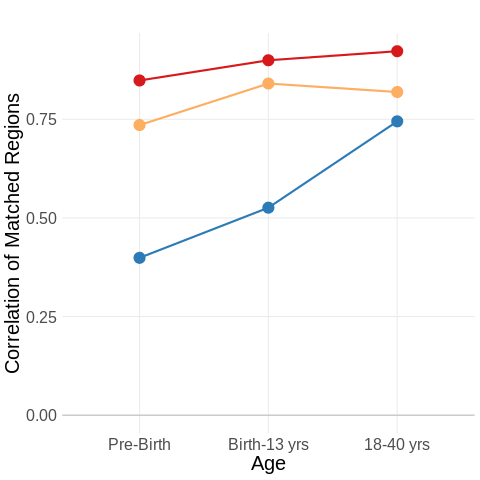

In [331]:
%%R -i bs_scores_corr
source("../code/brainspanPlots.R")
plot_bs_scores_corr(bs_scores_corr) & theme(text=element_text(size=20)) 

---

---

# Supplement

## 1 — Distributions

In [5]:
counts_hcp = pd.read_csv("../outputs/counts_hcp.csv", index_col=0)
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')
donor_counts = (counts_hcp!=0).sum(axis=1)[:180].rename('count').to_frame()

In [6]:
stability['ds'].quantile(.9)

0.3859072493003411

---

## 2 — Parcellations

In [88]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')
dm_dx_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dx_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9
New gradients version: method=dm, kernel=normalized_angle, data=dx_ds9


In [89]:
hcp_scores = dm_hcp_ds9.clean_scores().assign(version='HCP-MMP1.0,\ntop 10% DS genes')
dk_scores = dm_dk_ds9.clean_scores().assign(version='Desikan-Killiany,\ntop 10% DS genes')
dx_scores = dm_dx_ds9.clean_scores().assign(version='Desterieux,\ntop 10% DS genes')

## 2 — Parcellation gene weight corrs

In [91]:
corrs_dict = {
    'HCP-MMP1.0,\ntop 10% DS genes': correlate(dm_hcp_ds9.fit_weights(overwrite=False), weights_version.weights),
    'Desikan-Killiany,\ntop 10% DS genes': correlate(dm_dk_ds9.fit_weights(), weights_version.weights),
    'Desterieux,\ntop 10% DS genes': correlate(dm_dx_ds9.fit_weights(), weights_version.weights)
}

weight_corrs = (pd.concat(corrs_dict)
 .melt(ignore_index=False)
 .reset_index()
 .set_axis(['version','x','y','corr'], axis=1)
 .loc[lambda x: (x['x'] < 3) & (x['y'] < 3)]
 .replace({'x':{0:'G1',1:'G2',2:'G3'}, 'y':{0:'G1',1:'G2',2:'G3'}})
)

In [92]:
def count_gene_overlap(v1, v2):
    overlap = set(v1.weights.index).intersection(set(v2.weights.index))
    overlap_v1 = round(len(overlap)/len(v1.weights.index),2)*100
    overlap_v2 = round(len(overlap)/len(v2.weights.index),2)*100
    print(f'Overlap is {overlap_v1}% of v1 genes, {overlap_v2}% of v2 genes')
    
count_gene_overlap(dm_hcp_ds9, dm_dk_ds9)

Overlap is 85.0% of v1 genes, 85.0% of v2 genes


---

## MRI maps

In [187]:
maps = get_maps()#.drop(['Size Variation (allometric scaling)', 'fMRI PC1', 'NeuroSynth PC1'], axis=1)
null_corrs_dict = load_pickle('null_corrs_dict')

In [188]:
hcp_scores = dm_hcp_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(hcp_scores, maps, atlas='hcp')
null_corrs = null_corrs_dict['sim_grads_p']

mri_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

## Disorder maps

In [45]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9


In [189]:
maps = get_disorder_maps().drop(['ADHD', 'ANX', 'MCI'], axis=1)
null_corrs_dict_disorders = load_pickle('null_corrs_dict_disorders')

In [190]:
dk_scores = dm_dk_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(dk_scores, maps, atlas='dk')
null_corrs = null_corrs_dict_disorders['sim_grads_p']

disorder_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

## For plotting brains

In [96]:
maps_to_plot = [
    'Myelination (T1w/T2w ratio)',
    'Glycolytic Index (CMRO2/CMRGlu)',
    'Developmental Expansion'
]

hcp_maps = maps.loc[:, maps_to_plot]

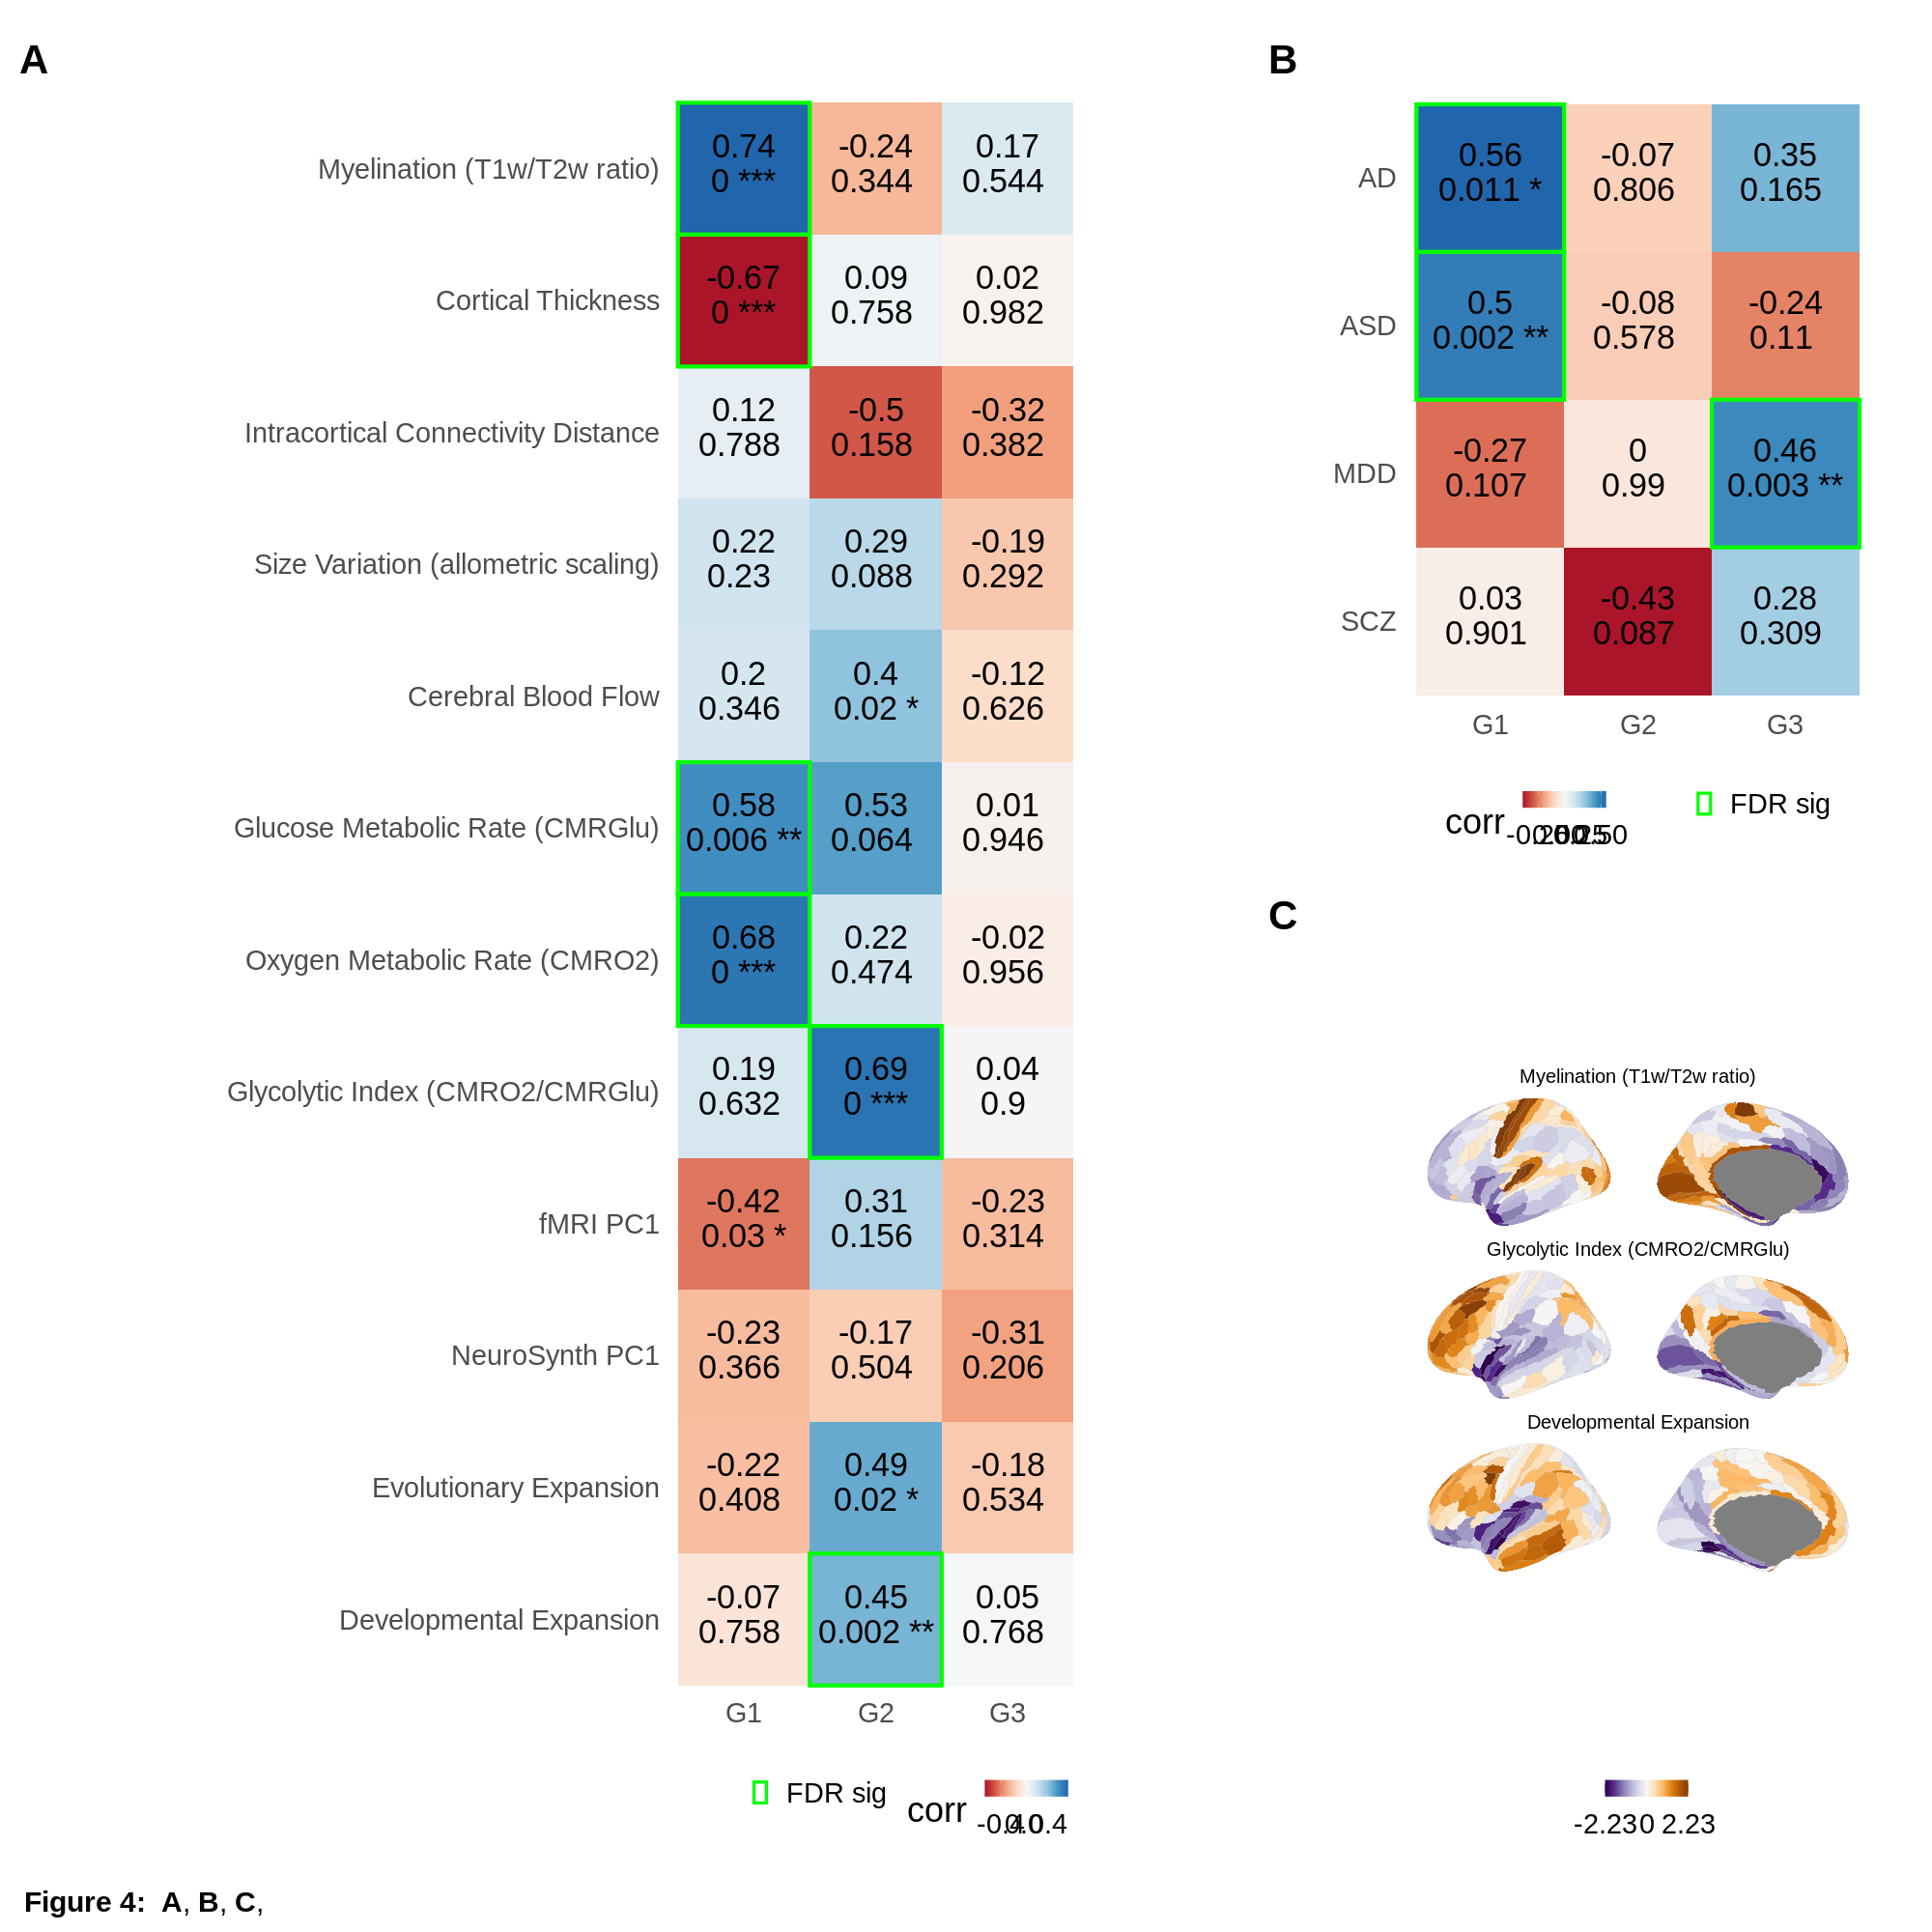

In [191]:
%%R -i mri_corrs -i disorder_corrs -i hcp_maps -w 2000 -h 2000
source("../code/plot_maps.R")
g1 <- plot_corr_versions(mri_corrs, size=12)
g2 <- plot_corr_versions(disorder_corrs, size=12)
g3 <- plot_maps(hcp_maps, ncol=1, colors=rev(brewer.puor(100)))

plot <- (
    g1 | 
    (g2 / g3)
) + plot_layout(widths=c(3,2))

themed <- plot & theme(
    text=element_text(size=36),
    plot.margin = margin(t=10, r=30, b=10, l=10, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)

caption <- paste("**Figure 4:**",
                "**A**, ",
                "**B**, ",
                "**C**, "
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated